<a href="https://colab.research.google.com/github/srinidhi98/Bird-Audio-Analysis/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       208
           1       0.85      0.89      0.87       477

    accuracy                           0.81       685
   macro avg       0.78      0.77      0.77       685
weighted avg       0.81      0.81      0.81       685



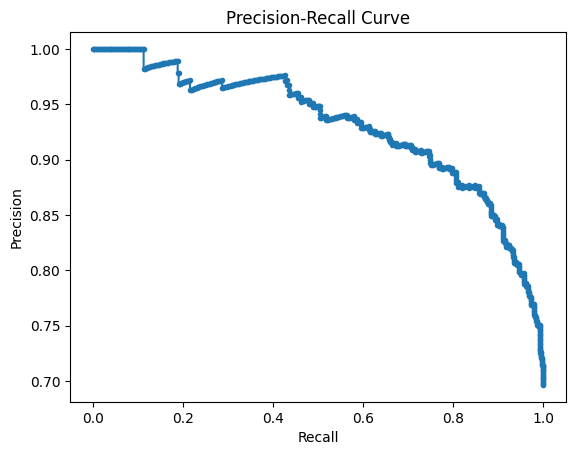

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       208
           1       0.87      0.79      0.83       477

    accuracy                           0.77       685
   macro avg       0.74      0.76      0.74       685
weighted avg       0.79      0.77      0.78       685



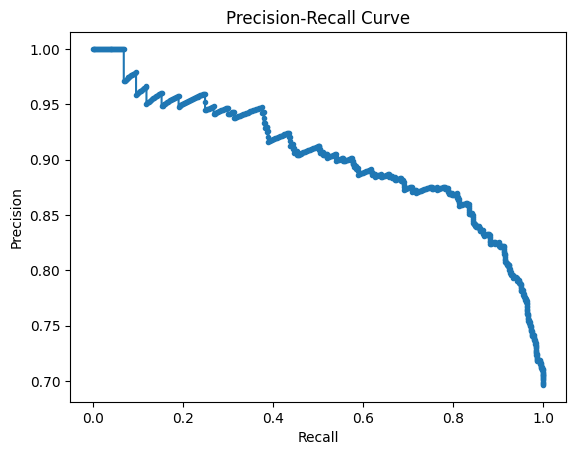

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import itertools
import matplotlib.pyplot as plt

# Function to calculate distances between body parts
def calculate_distances_fast(df, keypoints):
    distances = {}
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        distances[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    distances_df = pd.DataFrame(distances)
    return pd.concat([df, distances_df], axis=1)

# Function to calculate angles between three points
def calculate_angles(df, keypoints):
    angles = {}
    for (p1, p2, p3) in itertools.combinations(keypoints, 3):
        x1, y1 = f"{p1}_x", f"{p1}_y"
        x2, y2 = f"{p2}_x", f"{p2}_y"
        x3, y3 = f"{p3}_x", f"{p3}_y"
        angle_col = f"angle_{p1}_{p2}_{p3}"

        vec1_x = df[x1] - df[x2]
        vec1_y = df[y1] - df[y2]
        vec2_x = df[x3] - df[x2]
        vec2_y = df[y3] - df[y2]

        dot_product = vec1_x * vec2_x + vec1_y * vec2_y
        magnitude = (np.sqrt(vec1_x ** 2 + vec1_y ** 2) * np.sqrt(vec2_x ** 2 + vec2_y ** 2)) + 1e-6
        angles[angle_col] = np.arccos(dot_product / magnitude)
    angles_df = pd.DataFrame(angles)
    return pd.concat([df, angles_df], axis=1)

# Function to compute symmetry features
def calculate_symmetry(df):
    symmetries = {}
    for joint in ['sho', 'elb', 'wri', 'hip', 'knee', 'ankl']:
        left = f"l{joint}_x"
        right = f"r{joint}_x"
        symmetries[f"symmetry_{joint}"] = np.abs(df[left] - df[right])
    symmetry_df = pd.DataFrame(symmetries)
    return pd.concat([df, symmetry_df], axis=1)

# Confusion matrix printer
def print_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    print("\t\tPred")
    print("\t\tP0\tP1")
    print(f"True\tT0\t{cm[0,0]}\t{cm[0,1]}")
    print(f"\tT1\t{cm[1,0]}\t{cm[1,1]}\n")

    precision = cm[0,0] / (cm[0,0] + cm[1,0]) if cm[0,0] + cm[1,0] else 0.0
    recall = cm[0,0] / (cm[0,0] + cm[0,1]) if cm[0,0] + cm[0,1] else 0.0
    f1 = 2 * precision * recall / (precision + recall) if cm[0,0] > 0 else 0.0
    print(f"Class 0 - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if cm[1,1] + cm[0,1] else 0.0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if cm[1,1] + cm[1,0] else 0.0
    f1 = 2 * precision * recall / (precision + recall) if cm[1,1] > 0 else 0.0
    print(f"Class 1 - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}\n")

# Plot Precision-Recall Curve
def plot_pr_curve(y_test, y_scores):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Main code
def main():
    # Load dataset
    dataset = pd.read_csv('mpii_dataset.csv')

    # Extract keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Add distances, angles, and symmetry features
    dataset = calculate_distances_fast(dataset, keypoints)
    dataset = calculate_angles(dataset, keypoints)
    dataset = calculate_symmetry(dataset)

    # Define features and target
    X, y = dataset.drop(columns=['sport']), dataset['sport']

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Apply ADASYN for oversampling
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

    # XGBoost with hyperparameter tuning
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    param_dist = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'min_child_weight': [1, 3, 5]
    }

    randomized_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                           scoring='f1_macro', n_iter=30, cv=3, verbose=1, random_state=42, n_jobs=-1)
    randomized_search.fit(X_train_resampled, y_train_resampled)

    # Evaluate XGBoost
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]

    print("XGBoost Classification Report:")
    print(classification_report(y_test, y_pred))
    plot_pr_curve(y_test, y_scores)

    # Balanced Random Forest
    brf = BalancedRandomForestClassifier(random_state=42, n_estimators=200, max_depth=7)
    brf.fit(X_train_resampled, y_train_resampled)

    y_pred_brf = brf.predict(X_test)
    y_scores_brf = brf.predict_proba(X_test)[:, 1]

    print("Balanced Random Forest Classification Report:")
    print(classification_report(y_test, y_pred_brf))
    plot_pr_curve(y_test, y_scores_brf)

if __name__ == '__main__':
    main()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier

# Feature engineering function (distance computation remains same)
def calculate_distances(df, keypoints):
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return df

def optimize_hyperparameters(X_train, y_train):
    # Define parameter grid for XGBoost
    xgb_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'scale_pos_weight': [1, 2, 5]
    }
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_search = RandomizedSearchCV(
        xgb_model, xgb_params, scoring='f1_macro', n_iter=20, cv=3, random_state=42, n_jobs=-1
    )

    # Define parameter grid for Balanced Random Forest
    brf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt', 'log2', None]
    }
    brf_model = BalancedRandomForestClassifier(random_state=42)
    brf_search = RandomizedSearchCV(
        brf_model, brf_params, scoring='f1_macro', n_iter=20, cv=3, random_state=42, n_jobs=-1
    )

    # Fit models and return best
    print("Optimizing XGBoost...")
    xgb_search.fit(X_train, y_train)
    print("Optimizing Balanced Random Forest...")
    brf_search.fit(X_train, y_train)

    return xgb_search.best_estimator_, brf_search.best_estimator_

def main():
    # Load dataset
    dataset = pd.read_csv('mpii_dataset.csv')

    # Extract keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']
    dataset = calculate_distances(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=['sport']), dataset['sport']

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Optimize hyperparameters
    xgb_model, brf_model = optimize_hyperparameters(X_train_resampled, y_train_resampled)

    # Evaluate models
    for model_name, model in zip(["XGBoost", "Balanced Random Forest"], [xgb_model, brf_model]):
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        print(f"{model_name} Classification Report:")
        print(classification_report(y_test, y_pred))

if __name__ == '__main__':
    main()


Optimizing XGBoost...


<ipython-input-2-85e7d7720ddf>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-2-85e7d7720ddf>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-2-85e7d7720ddf>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Optimizing Balanced Random Forest...


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Evaluating XGBoost...
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       208
           1       0.85      0.90      0.87       477

    accuracy                           0.82       685
   macro avg       0.79      0.76      0.77       685
weighted avg       0.81      0.82      0.81       685

Evaluating Balanced Random Forest...
Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       208
           1       0.84      0.85      0.84       477

    accuracy                           0.78       685
   macro avg       0.74      0.73      0.74       685
weighted avg       0.78      0.78      0.78       685



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
import itertools
import math

# Function to calculate distances between body parts
def calculate_distances(df, keypoints):
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return df

# Function to calculate angles between body parts
def calculate_angles(df, keypoints):
    for (point1, point2, point3) in itertools.combinations(keypoints, 3):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        x3, y3 = f"{point3}_x", f"{point3}_y"
        angle_col = f"angle_{point1}_{point2}_{point3}"
        df[angle_col] = np.abs(
            np.degrees(
                np.arctan2(df[y3] - df[y2], df[x3] - df[x2])
                - np.arctan2(df[y1] - df[y2], df[x1] - df[x2])
            )
        )
    return df

# Function to calculate body-part ratios
def calculate_ratios(df, keypoints):
    for (point1, point2, point3, point4) in itertools.combinations(keypoints, 4):
        ratio_col = f"ratio_{point1}_{point2}_to_{point3}_{point4}"
        df[ratio_col] = df[f"dist_{point1}_{point2}"] / (
            df[f"dist_{point3}_{point4}"] + 1e-6
        )
    return df



# Main function
def main():
    # Load dataset
    dataset = pd.read_csv("mpii_dataset.csv")

    # Define keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Perform feature engineering
    dataset = calculate_distances(dataset, keypoints)
    dataset = calculate_angles(dataset, keypoints)
    dataset = calculate_ratios(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=["sport"]), dataset["sport"]

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train models
    xgb_model = xgb.XGBClassifier(random_state=42)
    brf_model = BalancedRandomForestClassifier(random_state=42)

    xgb_model.fit(X_train_resampled, y_train_resampled)
    brf_model.fit(X_train_resampled, y_train_resampled)

    # Evaluate models
    for model_name, model in zip(["XGBoost", "Balanced Random Forest"], [xgb_model, brf_model]):
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        print(f"{model_name} Classification Report:")
        print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main()


<ipython-input-6-83f6f8669a46>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-6-83f6f8669a46>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-6-83f6f8669a46>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Evaluating XGBoost...
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       208
           1       0.85      0.89      0.87       477

    accuracy                           0.82       685
   macro avg       0.79      0.77      0.77       685
weighted avg       0.81      0.82      0.81       685

Evaluating Balanced Random Forest...
Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       208
           1       0.84      0.88      0.86       477

    accuracy                           0.80       685
   macro avg       0.76      0.74      0.75       685
weighted avg       0.79      0.80      0.79       685



**Ensemble** **Methods**

In [ ]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
import itertools

# Function to calculate distances between body parts
def calculate_distances(df, keypoints):
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return df

# Main function
def main():
    # Load dataset
    dataset = pd.read_csv("mpii_dataset.csv")

    # Define keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Perform feature engineering
    dataset = calculate_distances(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=["sport"]), dataset["sport"]

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train individual models
    xgb_model = xgb.XGBClassifier(random_state=42)
    brf_model = BalancedRandomForestClassifier(random_state=42)

    xgb_model.fit(X_train_resampled, y_train_resampled)
    brf_model.fit(X_train_resampled, y_train_resampled)

    # Create an ensemble model with soft voting
    ensemble = VotingClassifier(
        estimators=[("xgb", xgb_model), ("brf", brf_model)], voting="soft"
    )
    ensemble.fit(X_train_resampled, y_train_resampled)

    # Evaluate ensemble
    y_pred = ensemble.predict(X_test)
    print("Ensemble Classification Report:")
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main()


<ipython-input-2-626211fed1b0>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-2-626211fed1b0>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-2-626211fed1b0>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       208
           1       0.86      0.86      0.86       477

    accuracy                           0.80       685
   macro avg       0.77      0.77      0.77       685
weighted avg       0.80      0.80      0.80       685



In [ ]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
import itertools

# Function to calculate distances between body parts
def calculate_distances(df, keypoints):
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return df

# Main function
def main():
    # Load dataset
    dataset = pd.read_csv("mpii_dataset.csv")

    # Define keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Perform feature engineering
    dataset = calculate_distances(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=["sport"]), dataset["sport"]

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train individual models
    xgb_model = xgb.XGBClassifier(random_state=42)
    brf_model = BalancedRandomForestClassifier(random_state=42)

    xgb_model.fit(X_train_resampled, y_train_resampled)
    brf_model.fit(X_train_resampled, y_train_resampled)

    # Create an ensemble model with soft voting
    ensemble = VotingClassifier(
    estimators=[("xgb", xgb_model), ("brf", brf_model)],
    voting="soft",
    weights=[2, 1]  # Giving XGBoost higher importance
)

    ensemble.fit(X_train_resampled, y_train_resampled)

    # Evaluate ensemble
    y_pred = ensemble.predict(X_test)
    print("Ensemble Classification Report:")
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main()


<ipython-input-3-2f3a8a69d49c>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-3-2f3a8a69d49c>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-3-2f3a8a69d49c>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       208
           1       0.86      0.86      0.86       477

    accuracy                           0.80       685
   macro avg       0.76      0.76      0.76       685
weighted avg       0.80      0.80      0.80       685



In [ ]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import itertools

# Function to calculate distances between body parts
def calculate_distances(df, keypoints):
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return df

from sklearn.metrics import confusion_matrix

def print_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    print("\t\tPredicted")
    print("\t\tClass 0\tClass 1")
    print(f"Actual Class 0\t{cm[0, 0]}\t{cm[0, 1]}")
    print(f"Actual Class 1\t{cm[1, 0]}\t{cm[1, 1]}\n")

    # Calculate and display precision, recall, and F1-score for each class
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0.0
    recall_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0.0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0.0

    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0.0
    recall_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0.0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0.0

    print(f"Class 0 - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1-Score: {f1_0:.2f}")
    print(f"Class 1 - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1-Score: {f1_1:.2f}")

# Main function
def main():
    # Load dataset
    dataset = pd.read_csv("mpii_dataset.csv")

    # Define keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Perform feature engineering
    dataset = calculate_distances(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=["sport"]), dataset["sport"]

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train individual models
    xgb_model = xgb.XGBClassifier(random_state=42)
    brf_model = BalancedRandomForestClassifier(random_state=42)

    xgb_model.fit(X_train_resampled, y_train_resampled)
    brf_model.fit(X_train_resampled, y_train_resampled)


    # Define stacking classifier
    stacking_ensemble = StackingClassifier(
    estimators=[("xgb", xgb_model), ("brf", brf_model)],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

    # Train stacking ensemble
    stacking_ensemble.fit(X_train_resampled, y_train_resampled)

    # Evaluate on test set
    y_pred_stacking = stacking_ensemble.predict(X_test)

    # Classification Report
    print("Stacking Ensemble Classification Report:")
    print(classification_report(y_test, y_pred_stacking))

    # Confusion Matrix
    print_confusion_matrix(y_test, y_pred_stacking)

if __name__ == "__main__":
  main()


<ipython-input-7-633b4db86994>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-7-633b4db86994>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-7-633b4db86994>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       208
           1       0.84      0.88      0.86       477

    accuracy                           0.80       685
   macro avg       0.77      0.75      0.76       685
weighted avg       0.80      0.80      0.80       685

		Predicted
		Class 0	Class 1
Actual Class 0	131	77
Actual Class 1	59	418

Class 0 - Precision: 0.69, Recall: 0.63, F1-Score: 0.66
Class 1 - Precision: 0.84, Recall: 0.88, F1-Score: 0.86


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import itertools

# Function to calculate distances between body parts
def calculate_distances(df, keypoints):
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return df

# Main function
def main():
    # Load dataset
    dataset = pd.read_csv("mpii_dataset.csv")

    # Define keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Perform feature engineering
    dataset = calculate_distances(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=["sport"]), dataset["sport"]

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
    X = pca.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Hyperparameter tuning for XGBoost
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_params = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [1, 2]
    }
    xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=xgb_params,
        n_iter=50,
        scoring="f1_macro",
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    xgb_search.fit(X_train_resampled, y_train_resampled)
    xgb_best = xgb_search.best_estimator_

    # Hyperparameter tuning for Balanced Random Forest
    brf_model = BalancedRandomForestClassifier(random_state=42)
    brf_params = {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "sampling_strategy": ["auto", 0.8],
        "max_features": ["sqrt", "log2"]
    }
    brf_search = RandomizedSearchCV(
        estimator=brf_model,
        param_distributions=brf_params,
        n_iter=50,
        scoring="f1_macro",
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    brf_search.fit(X_train_resampled, y_train_resampled)
    brf_best = brf_search.best_estimator_

    # Create an optimized ensemble model with soft voting
    ensemble = VotingClassifier(
        estimators=[("xgb", xgb_best), ("brf", brf_best)],
        voting="soft",
        weights=[2, 1]  # Give more weight to XGBoost if it performs better
    )
    ensemble.fit(X_train_resampled, y_train_resampled)

    # Evaluate ensemble
    y_pred = ensemble.predict(X_test)
    print("Optimized Ensemble Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

if __name__ == "__main__":
    main()


<ipython-input-1-110128aca337>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-1-110128aca337>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
<ipython-input-1-110128aca337>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

Optimized Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63       208
           1       0.82      0.91      0.86       477

    accuracy                           0.80       685
   macro avg       0.78      0.73      0.75       685
weighted avg       0.79      0.80      0.79       685

Confusion Matrix:
[[115  93]
 [ 43 434]]


In [ ]:
import pandas as pd
import numpy as np
import itertools
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb

# Function to calculate distances between body parts
def calculate_distances(df, keypoints):
    distance_data = {}
    for (point1, point2) in itertools.combinations(keypoints, 2):
        x1, y1 = f"{point1}_x", f"{point1}_y"
        x2, y2 = f"{point2}_x", f"{point2}_y"
        distance_col = f"dist_{point1}_{point2}"
        distance_data[distance_col] = np.sqrt((df[x2] - df[x1]) ** 2 + (df[y2] - df[y1]) ** 2)
    return pd.concat([df, pd.DataFrame(distance_data)], axis=1)

def main():
    # Load dataset
    dataset = pd.read_csv("mpii_dataset.csv")

    # Define keypoints for feature engineering
    keypoints = ['head', 'upper_neck', 'thorax', 'lsho', 'rsho', 'lelb', 'relb',
                 'lwri', 'rwri', 'lhip', 'rhip', 'lknee', 'rknee', 'lankl', 'rankl']

    # Perform feature engineering
    dataset = calculate_distances(dataset, keypoints)

    # Define features and target
    X, y = dataset.drop(columns=["sport"]), dataset["sport"]

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.99, random_state=42)  # Retain 99% variance
    X = pca.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Compute class weights
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
    class_weight_ratio = class_weights[0] / class_weights[1]

    # Define models
    xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False)
    brf_model = BalancedRandomForestClassifier(random_state=42)

    # Hyperparameter tuning for XGB
    xgb_params = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "scale_pos_weight": [class_weight_ratio],
    }
    xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=xgb_params,
        n_iter=40,
        scoring="f1_macro",
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    xgb_search.fit(X_train_resampled, y_train_resampled)

    # Hyperparameter tuning for BRF
    brf_params = {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "sampling_strategy": ["not minority", 0.8],
        "max_features": ["sqrt", "log2"],
    }
    brf_search = RandomizedSearchCV(
        estimator=brf_model,
        param_distributions=brf_params,
        n_iter=40,
        scoring="f1_macro",
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    brf_search.fit(X_train_resampled, y_train_resampled)

    # Combine models in a stacking ensemble
    stack = StackingClassifier(
        estimators=[("xgb", xgb_search.best_estimator_), ("brf", brf_search.best_estimator_)],
        final_estimator=LogisticRegression(),
        cv=3
    )
    stack.fit(X_train_resampled, y_train_resampled)

    # Evaluate the model
    y_pred = stack.predict(X_test)
    print("Optimized Ensemble Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:08:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/

Optimized Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       208
           1       0.82      0.90      0.86       477

    accuracy                           0.80       685
   macro avg       0.77      0.73      0.74       685
weighted avg       0.79      0.80      0.79       685

Confusion Matrix:
[[114  94]
 [ 46 431]]
